### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

Text(-45, 55, 'NAH')

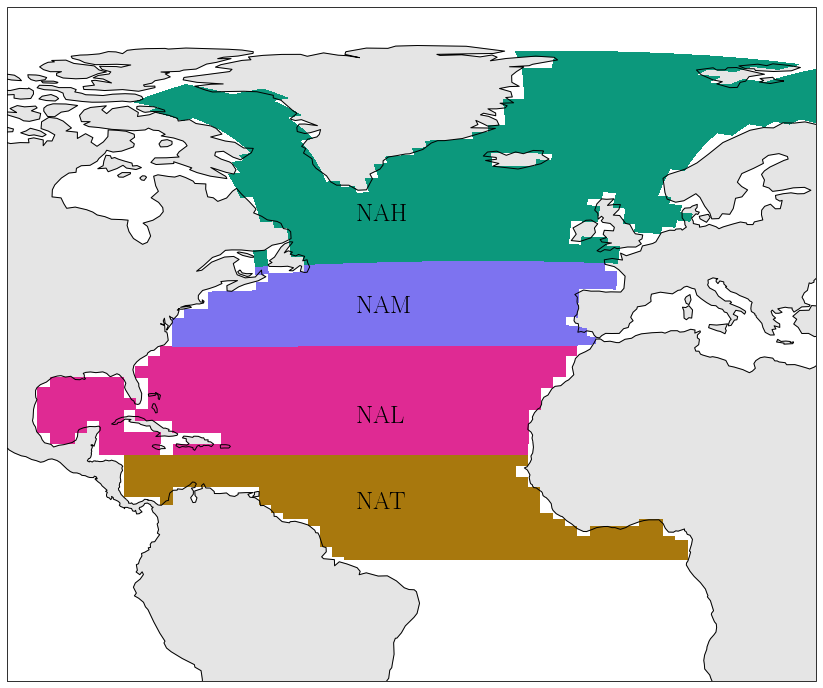

In [4]:
atl = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/meshmask_with_Atl.nc')

    
regs = ['NAT', 'NAL', 'NAM', 'NAH']#, 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'NAT' : {'number' : 1},
           'NAL' : {'number': 2},
          'NAM' : {'number': 3},
           'NAH' : {'number': 4},
           
          }

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[atl[regs[i]][0,0,:,:] == 1] = regdict[regs[i]]['number']
maskno[maskno == 0] = np.nan

fact = 1
tfig = plt.figure(figsize=[14.5*fact, 14.5*fact])
ax = plt.axes(projection=ccrs.PlateCarree())

year = 1984
tgrid = xr.open_dataset(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_RVA0/ORCA2_1m_{year}0101_{year}1231_ptrc_T.nc')

nav_lon = tgrid['nav_lon'].values
nav_lat = tgrid['nav_lat'].values
mesh = ax.pcolormesh(nav_lon, nav_lat, maskno, transform=ccrs.PlateCarree(), cmap=cm.phase, zorder =0, alpha = 1,\
                    vmin = 1, vmax = 5)

ax.coastlines(zorder = 1 )
#lons, lats extent
ax.set_extent([ -102, 30, -20, 120,], crs=ccrs.PlateCarree())

ax.add_feature(cp.feature.LAND, color='grey', alpha = 0.2)

ax.text(-45, 8, s = f'NAT', color='k', \
        fontsize = 25, fontweight = 'bold', transform=ccrs.Geodetic())
ax.text(-45, 22, s = f'NAL', color='k', \
        fontsize = 25, fontweight = 'bold', transform=ccrs.Geodetic())
ax.text(-45, 40, s = f'NAM', color='k', \
        fontsize = 25, fontweight = 'bold', transform=ccrs.Geodetic())
ax.text(-45, 55, s = f'NAH', color='k', \
        fontsize = 25, fontweight = 'bold', transform=ccrs.Geodetic())

In [5]:
tdir = '/gpfs/home/mep22dku/scratch/ModelRuns/TOM12_TJ_LC00/'

tfi = 'ORCA2_1m_19230101_19231231_diad_T.nc'

w = xr.open_dataset(f'{tdir}/{tfi}')



In [6]:
print(list(w.data_vars))

['deptht_bounds', 'DOCTRP', 'time_centered_bounds', 'time_counter_bounds', 'CARBTRP', 'CAPITRP', 'ALKTRP', 'EXP', 'GRAMIC', 'GRAMES', 'GRAMAC', 'PPTDOC', 'PPT', 'TChl', 'Detrit', 'Carniv', 'Herbiv', 'GRAMICPHY', 'GRAPTEPHY', 'GRAMESPHY', 'GRAGELPHY', 'GRAMACPHY', 'nitrfix', 'denitr', 'DELO2', 'vsink', 'sinksil', 'discarb', 'ExpCO3', 'ExpARA', 'GRAGEL', 'GRAPTE', 'proara', 'prococ', 'lim2mmfe_dia', 'lim2mmfe_mix', 'lim2mmfe_coc', 'lim2mmfe_pic', 'lim2mmfe_pha', 'lim2mmfe_fix', 'lim3fe_dia', 'lim3fe_mix', 'lim3fe_coc', 'lim3fe_pic', 'lim3fe_pha', 'lim3fe_fix', 'lim4po4_dia', 'lim4po4_mix', 'lim4po4_coc', 'lim4po4_pic', 'lim4po4_pha', 'lim4po4_fix', 'lim5si_dia', 'lim6din_dia', 'lim6din_mix', 'lim6din_coc', 'lim6din_pic', 'lim6din_pha', 'lim6din_fix', 'lim8light_dia', 'lim8light_mix', 'lim8light_coc', 'lim8light_pic', 'lim8light_pha', 'lim8light_fix', 'Cflx', 'PICflx', 'Oflx', 'dpCO2', 'pCO2', 'PPINT']


In [17]:
# Stack variables [A, B, C, D] into a single DataArray along a new dimension

def get_limiter(run = 'TOM12_TJ_LC00', year = 1920):

    tdir = f'/gpfs/data/greenocean/software/runs/{run}/'

    tfi = f'ORCA2_1m_{year}0101_{year}1231_diad_T.nc'

    w = xr.open_dataset(f'{tdir}/{tfi}')
    print(f'{run} {year}')
    
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    tm = tmesh.tmask.values
    print(np.shape(tm))
    tm_broad = np.zeros([12,31, 149, 182])
    for i in range(0,12):
        tm_broad[i,:,:,:] = tm[0,:,:,:]
    #lim3fe_dia', 'lim3fe_mix', 'lim3fe_coc', 'lim3fe_pic', 'lim3fe_pha', 'lim3fe_fix', 
    pfts = ['dia','mix','coc','pic','pha','fix']

    for pft in pfts:

        A = f'lim3fe_{pft}'
        B = f'lim4po4_{pft}'
        if pft == 'dia':
            C = f'lim5si_{pft}'
        D = f'lim6din_{pft}'
        E = f'LV_{pft}'
        if pft == 'dia':
            stacked = xr.concat([w[A], w[B], w[C], w[D]], dim='variable')
        else:
            stacked = xr.concat([w[A], w[B], w[D]], dim='variable')

        stacked = stacked.where(stacked != 0, np.nan)
        stacked = stacked.fillna(np.inf)

        # Find the minimum values across the new 'variable' dimension
        w[E] = stacked.min(dim='variable', skipna = True)

        # Find the index of the minimum values (this will give 0, 1, 2, 3)
        min_indices = stacked.argmin(dim='variable', skipna = True)
        q2 = np.copy(min_indices).astype(float)
        q2[np.where(tm_broad == 0)] = np.nan
        # Add 1 to match the [1, 2, 3, 4] numbering scheme
        q3 = (q2+1)*10

        if pft == 'dia':
            q3[q3 == 10] = 3
            q3[q3 == 20] = 4
            q3[q3 == 30] = 5
            q3[q3 == 40] = 6
        else:
            q3[q3 == 10] = 3
            q3[q3 == 20] = 4
            q3[q3 == 30] = 6
            
        q3[np.where(tm_broad == 0)] = np.nan
        w[f'LN_{pft}'] = w[f'LV_{pft}']
        w[f'LN_{pft}'].data = q3
        
    if year == 1940:
        plt.figure()
        plt.pcolormesh(w['LN_dia'][0,0,:,:])
        plt.figure()
        plt.pcolormesh(w['LN_mix'][0,0,:,:])
        
    # Now your dataset `ds` has the two new variables

    w_sel = w[['LV_dia', 'LN_dia', 'LV_mix', 'LN_mix', 'LV_coc', 'LN_coc', 'LV_pic', 'LN_pic', 'LV_pha', 'LN_pha', 'LV_fix', 'LN_fix']]
    
    try:
        w_sel.to_netcdf(f'{tdir}/ORCA2_1m_{year}0101_{year}1231_LoP_T.nc')
        print(f'saved {run} {year}')
    except:
        print(f'failed 2 save {run} {year}')

In [18]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tm = tmesh.tmask.values
print(np.shape(tm))
tm_broad = np.zeros([12,31, 149, 182])
for i in range(0,12):
    tm_broad[i,:,:,:] = tm[0,:,:,:]

(1, 31, 149, 182)


TOM12_TJ_LA02 1940
(1, 31, 149, 182)
saved TOM12_TJ_LA02 1940
TOM12_TJ_LC02 1940
(1, 31, 149, 182)
saved TOM12_TJ_LC02 1940
TOM12_TJ_LA02 1941
(1, 31, 149, 182)
saved TOM12_TJ_LA02 1941
TOM12_TJ_LC02 1941
(1, 31, 149, 182)
saved TOM12_TJ_LC02 1941
TOM12_TJ_LA02 1942
(1, 31, 149, 182)
saved TOM12_TJ_LA02 1942
TOM12_TJ_LC02 1942
(1, 31, 149, 182)
saved TOM12_TJ_LC02 1942
TOM12_TJ_LA02 1943
(1, 31, 149, 182)
saved TOM12_TJ_LA02 1943
TOM12_TJ_LC02 1943
(1, 31, 149, 182)
saved TOM12_TJ_LC02 1943
TOM12_TJ_LA02 1944
(1, 31, 149, 182)
saved TOM12_TJ_LA02 1944
TOM12_TJ_LC02 1944
(1, 31, 149, 182)
saved TOM12_TJ_LC02 1944
TOM12_TJ_LA02 1945
(1, 31, 149, 182)
saved TOM12_TJ_LA02 1945
TOM12_TJ_LC02 1945
(1, 31, 149, 182)
saved TOM12_TJ_LC02 1945
TOM12_TJ_LA02 1946
(1, 31, 149, 182)
saved TOM12_TJ_LA02 1946
TOM12_TJ_LC02 1946
(1, 31, 149, 182)
saved TOM12_TJ_LC02 1946
TOM12_TJ_LA02 1947
(1, 31, 149, 182)
saved TOM12_TJ_LA02 1947
TOM12_TJ_LC02 1947
(1, 31, 149, 182)
saved TOM12_TJ_LC02 1947
TOM12_TJ

IndexError: index 9 is out of bounds for axis 0 with size 9

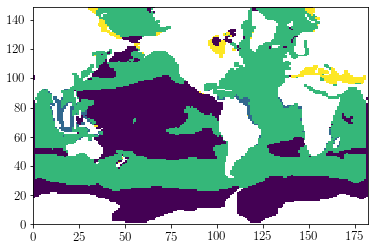

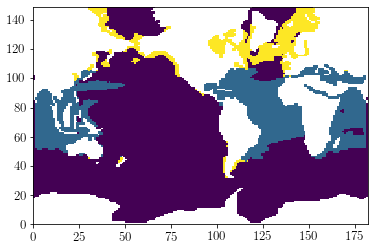

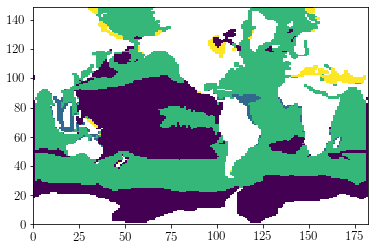

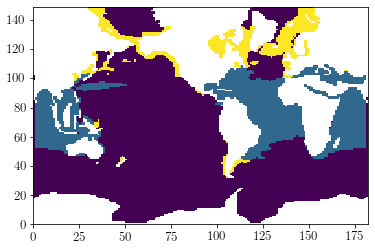

In [19]:

for year in range(1940,1974):
    
    get_limiter('TOM12_TJ_LA02', year)
    get_limiter('TOM12_TJ_LC02', year)

In [9]:


w = plt.pcolormesh(w_sel['LN_dia'][0,0,:,:])

NameError: name 'w_sel' is not defined

In [ ]:

def get_val(w, w_sel, y, x, d = 0, t = 0):
    
    lovdia = ['lim3fe_dia', 'lim4po4_dia', 'lim5si_dia', 
     'lim6din_dia',]

    for l in lovdia:
        tval = w[l][t,d,y,x].values
        print(f'{l}, {tval}')
    print(w_sel['LV_dia'][t,d,y,x].values)
    print(w_sel['LN_dia'][t,d,y,x].values)
        
get_val(w, w_sel, 20, 60, d = 0, t = 0)


def get_val2(w, w_sel, y, x, d = 0, t = 0):
    
    lovpha = ['lim3fe_pha', 'lim4po4_pha',
     'lim6din_pha',]

    for l in lovpha:
        tval = w[l][t,d,y,x].values
        print(f'{l}, {tval}')
    print(w_sel['LV_pha'][t,d,y,x].values)
    print(w_sel['LN_pha'][t,d,y,x].values)
        
get_val2(w, w_sel, 80, 70, d = 0, t = 0)

In [ ]:
print(np.nanmin(w_sel['LN_coc'][0,0,:,:]))

In [ ]:
np.shape(q2)

In [ ]:
plt.figure()
plt.pcolormesh(stacked[1,0,0,:,:])
q = stacked.argmin(dim='variable', skipna = False)
q2 = np.copy(q).astype(float)
q2[np.where(tmesh.tmask.values == 0)] = np.nan
plt.pcolormesh(q2[0,0,:,:])

tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
#q = q.where(tmesh['tmask'] != 0, np.nan)
#q

print(q)
#plt.pcolormesh(q[0,0,:,:])

In [ ]:
print(q[0,0,10,10])

plt.pcolormesh(w['lim3fe_dia'][0,0,:,:])

In [ ]:
# Stack variables [A, B, C, D] into a single DataArray along a new dimension

def get_limitert(run = 'TOM12_TJ_LC00', year = 1920):

    tdir = f'/gpfs/data/greenocean/software/runs/{run}/'

    tfi = f'ORCA2_1m_{year}0101_{year}1231_diad_T.nc'

    w = xr.open_dataset(f'{tdir}/{tfi}')
    
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    #lim3fe_dia', 'lim3fe_mix', 'lim3fe_coc', 'lim3fe_pic', 'lim3fe_pha', 'lim3fe_fix', 
    pfts = ['dia','mix']#,'coc','pic','pha','fix']

    for pft in pfts:

        A = f'lim3fe_{pft}'
        B = f'lim4po4_{pft}'
        if pft == 'dia':
            C = f'lim5si_{pft}'
        D = f'lim6din_{pft}'
        E = f'LV_{pft}'
        if pft == 'dia':
            stacked = xr.concat([w[A], w[B], w[C], w[D]], dim='variable')
        else:
            stacked = xr.concat([w[A], w[B], w[D]], dim='variable')

        stacked = stacked.where(stacked != 0, np.nan)
        stacked = stacked.fillna(np.inf)

        # Find the minimum values across the new 'variable' dimension
        w[E] = stacked.min(dim='variable', skipna = True)

        # Find the index of the minimum values (this will give 0, 1, 2, 3)
        min_indices = stacked.argmin(dim='variable', skipna = True)
        q2 = np.copy(min_indices).astype(float)
        q2[np.where(tmesh.tmask.values == 0)] = np.nan
        # Add 1 to match the [1, 2, 3, 4] numbering scheme
        q3 = (q2+1)*10

        if pft == 'dia':
            q3[q3 == 10] = 3
            q3[q3 == 20] = 4
            q3[q3 == 30] = 5
            q3[q3 == 40] = 6
        else:
            q3[q3 == 10] = 3
            q3[q3 == 20] = 4
            q3[q3 == 30] = 6

        q3[np.where(tmesh.tmask.values == 0)] = np.nan
        
        w[f'LN_{pft}'] = w[f'LV_{pft}']
        w[f'LN_{pft}'].data = q3

    plt.figure()
    plt.pcolormesh(w['LN_dia'][0,0,:,:])
    plt.figure()
    plt.pcolormesh(w['LN_mix'][0,0,:,:])
    # Now your dataset `ds` has the two new variables

    w_sel = w[['LV_dia', 'LN_dia', 'LV_mix', 'LN_mix', 'LV_coc', 'LN_coc', 'LV_pic', 'LN_pic', 'LV_pha', 'LN_pha', 'LV_fix', 'LN_fix']]
    
#     try:
#         w_sel.to_netcdf(f'{tdir}/ORCA2_1m_{year}0101_{year}1231_LoP_T.nc')
#         print(f'saved {run} {year}')
#     except:
#         print(f'failed 2 save {run} {year}')
        
get_limitert('TOM12_TJ_LC02', 1940)